https://docs.scipy.org/doc/scipy/reference/cluster.vq.html


## Word Distribution Cluster Analysis

In [4]:
%load_ext autoreload
%autoreload 2

import collections
import itertools
import types
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
import bokeh.palettes
import seaborn as sns
from IPython.display import display

output_notebook()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

Load previously vectorized corpus. The corpus was created using the following settings:

 - Tokens were converted to lower case.
 - Only tokens that contains at least one alphanumeric character (isalnum).
 - Accents are ot removed (deacc)
 - Min token length 2 (min_len)
 - Max length not set (max_len)
 - Numerals are removed (numerals, -N)
 - Symbols are removed (symbols, -S)

The loaded corpus is processed in the following ways:

 - Exclude tokens having a total word count less than 10000
 - Include at most 50000 most frequent words words.
 - Group documents by year (y_corpus).
 - Check! Normalize token count based on each year's total token count. 
 - Normalize token distrubution over years to 1.0 (n_corpus).

In [5]:
import westac.common.vectorized_corpus as vectorized_corpus

folder = '/home/roger/source/welfare_state_analytics/output'

y_corpus = vectorized_corpus\
    .load_corpus(
        'SOU_1945-1989_L0_+N_+S',
        folder,
        n_count=10000,
        n_top=50000,
        axis=1,
        keep_magnitude=False
    )

n_corpus = y_corpus.normalize(axis=0)


Compute diffrent kinds of deviation metrics from the uniform distribution.

TODO: Add references to methods

Computes L2 norm for rows (axis = 1) or columns (axis = 0).

    See stats.stackexchange.com/questions/25827/how-does-one-measure-the-non-uniformity-of-a-distribution

    Measures distance tp unform distribution (1/sqrt(d))

    "The lower bound 1d√ corresponds to uniformity and upper bound to the 1-hot vector."

    "It just so happens, though, that the L2 norm has a simple algebraic connection to the χ2 statistic used in goodness of fit tests:
    that's the reason it might be suitable to measure non-uniformity"
    



In [6]:
import westac.common.goodness_of_fit as gof

df_gof = gof.compute_goddness_of_fits_to_uniform(n_corpus)


/home/roger/source/welfare_state_analytics/westac/common/goodness_of_fit.py:120: RuntimeWarning: divide by zero encountered in log
  kld = np.sum(p * np.log(p / q))
/home/roger/source/welfare_state_analytics/westac/common/goodness_of_fit.py:120: RuntimeWarning: invalid value encountered in multiply
  kld = np.sum(p * np.log(p / q))


In [7]:
display(df_gof.head())

df_gof.to_csv('df_gof.txt', sep='\t')


,token,word_count,l2_norm,slope,intercept,chi2_stats,chi2_p,min,max,mean,var,earth_mover,entropy,kld,skew
782,gud,10921,0.512080,-3.251907,0.001665,11.279110,1.0,0.000000,0.474885,0.022222,0.005570,0.033243,1.910897,NaN,5.171020
371,dig,10950,0.473419,-3.393535,0.001737,9.564300,1.0,0.000138,0.440037,0.022222,0.004723,0.031198,1.677691,1.677691,5.143007
1096,les,10846,0.395326,-0.001594,0.000012,6.493700,1.0,0.000226,0.327239,0.022222,0.003207,0.028128,1.406280,1.406280,4.184789
1860,ti11,15808,0.354812,-4.642240,0.002371,5.107898,1.0,0.000000,0.227735,0.022222,0.002522,0.033827,1.630928,NaN,2.537909
2130,vo,10925,0.344646,-0.697267,0.000366,4.782363,1.0,0.000140,0.202672,0.022222,0.002362,0.032384,1.436959,1.436959,2.494539


In [8]:
df_most_deviating = gof.compile_most_deviating_words(df_gof, n_count=2000)
display(df_most_deviating.head())
#df_most_deviating.to_csv('df_most_deviating.txt', sep='\t')

# df_most_deviating.hist(by='l2_norm', bins=100, grid=False)

,l2_norm_token,l2_norm,slope_token,slope,chi2_stats_token,chi2_stats,earth_mover_token,earth_mover,kld_token,kld,entropy_token,entropy
0,gud,0.512080,ti11,-4.642240,gud,11.279110,ti11,0.033827,dig,1.677691,gud,1.910897
1,dig,0.473419,voro,4.213594,dig,9.564300,gud,0.033243,vo,1.436959,dig,1.677691
2,les,0.395326,bla,-3.848444,les,6.493700,vo,0.032384,les,1.406280,ti11,1.630928
3,ti11,0.354812,äro,3.832485,ti11,5.107898,dig,0.031198,eo,0.931920,vo,1.436959
4,vo,0.344646,bliva,3.805094,vo,4.782363,les,0.028128,kyrkan,0.851060,les,1.406280


In [9]:
from scipy.stats.kde import gaussian_kde

def plot_metric_histogram(x_corpus, metric = 'l2_norm', bins=100):

    token_column = metric + '_token'

    xs  = np.arange(df_gof[metric].min(), df_gof[metric].max(), 0.1)
    pdf = gaussian_kde(df_gof[metric])

    p   = bokeh.plotting.figure(plot_height=300)

    p.line(xs, pdf(xs))

    hist, edges = np.histogram(df_gof[metric], density=True, bins=bins)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], alpha=0.4)

    p.title.text = metric.upper()

    return p

gp = gridplot([
    [
        plot_metric_histogram(n_corpus, metric = 'l2_norm', bins=100),
        plot_metric_histogram(n_corpus, metric = 'earth_mover', bins=100),
        plot_metric_histogram(n_corpus, metric = 'entropy', bins=100)
    ]
])

show(gp)


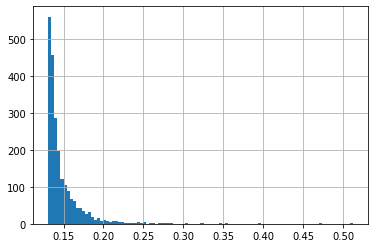

In [10]:
df_gof.l2_norm.hist(bins=100)

## Compute goddness-of-fit to Uniform Distribution

In [11]:
def plot_distributions(x_corpus, most_deviating, metric, columns=2, rows=1, start=0):

    min_year = x_corpus.document_index.year.min()
    max_year = x_corpus.document_index.year.max()

    token_column = metric + '_token'
    indices = [ x_corpus.token2id[token] for token in most_deviating[token_column] ]

    xs = np.arange(min_year, max_year + 1, 1)

    p_grid = []
    for r in range(0, rows):
        p_row = []
        for c in range(0, columns):
            i = start + r * rows + c

            token_id = indices[i]
            token = x_corpus.id2token[token_id] 

            ys = x_corpus.data[:,indices[i]]

            p = figure(plot_width=600, plot_height=400)

            p.title.text = token.upper()

            p.xaxis.axis_label = 'Year'
            p.yaxis.axis_label = 'Frequency'

            p.scatter(xs, ys, size=6, color="navy", alpha=0.5)
            p.line(x=xs, y=ys, line_width=2, color="navy", alpha=0.5)
            p.vbar(x=xs, top=ys, width=0.5, color="navy", alpha=0.1)
            #p.step(xs, ys, line_width=2, color="navy", alpha=0.5)

            _, _, _, lx, ly = gof.fit_ordinary_least_square(ys, xs)
            p.line(x=lx, y=ly, line_width=2, color="red", alpha=0.5)

            p_row += [p]

        p_grid += [p_row]

    p = gridplot(p_grid)
    show(p)

def display_plot_distributions_gui(x_corpus, most_deviating, metric):

    n_start_index = ipywidgets.IntSlider(min=0, max=len(most_deviating)-4, step=1)

    def update_plot(*args):

        plot_distributions(x_corpus, most_deviating, metric, columns=2, rows=2, start=n_start_index.value)

        x_widget.max = 2.0 * y_widget.value

    n_start_index.observe(update_plot, 'value')

    plot_distributions(n_corpus, df_most_deviating, metric, columns=2, rows=2, start=0)

    display(n_start_index)

# filter op cluster istället för metric
display_plot_distributions_gui(n_corpus, df_most_deviating, 'l2_norm')


IntSlider(value=0, max=1996)

## Linear Regression Fit (Slopes)

In [12]:

def generate_slope_data(x_corpus, most_deviating, metric):

    min_year = x_corpus.document_index.year.min()
    max_year = x_corpus.document_index.year.max()
    xs = np.arange(min_year, max_year + 1, 1)
    token_ids = [  x_corpus.token2id[token] for token in most_deviating[metric + '_token'] ]
    data = collections.defaultdict(list)
    # plyfit of all columns: kx_m = np.polyfit(x=xs, y=x_corpus.data[:,token_ids], deg=1)
    for token_id in token_ids:
        ys = x_corpus.data[:,token_id]
        data["token_id"].append(token_id)
        data["token"].append(x_corpus.id2token[token_id])
        _, k, p, lx, ly = gof.fit_ordinary_least_square(ys, xs)
        data['k'].append(k)
        data['p'].append(p)
        data['xs'].append(np.array(lx))
        data['ys'].append(np.array(ly))
    return data

def plot_slope_data(x_corpus, most_deviating, metric):

    data = generate_slope_data(x_corpus, most_deviating, metric)

    source = bokeh.models.ColumnDataSource(data)
    
    palette = itertools.cycle(bokeh.palettes.Category20[20])

    color_mapper = bokeh.models.LinearColorMapper(palette='Magma256', low=min(data['k']), high=max(data['k']))

    p = figure(plot_height=400, tools='pan,wheel_zoom,box_zoom,reset')
    p.multi_line(xs='xs', ys='ys', line_width=1, line_color={'field': 'k', 'transform': color_mapper}, line_alpha=0.6,hover_line_alpha=1.0, source=source) #, legend="token"

    p.add_tools(
        bokeh.models.HoverTool(
            show_arrow=False,
            line_policy='next',
            tooltips=[('Token', '@token'), ('Slope', '@k{1.1111}')] #, ('P-value', '@p{1.1111}')]
        ))

    show(p)

plot_slope_data(n_corpus, df_most_deviating, 'l2_norm')
# plot his


## Cluster Analysis

https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

### K-Means


In [13]:

import sklearn.cluster
import numpy as np
import pandas as pd
import westac.common.cluster_analysis as ca

output_notebook()

def plot_kmean_clusters(x_corpus, df_clusters, n_cluster):

    palette = itertools.cycle(bokeh.palettes.Category20[20])
    assert n_cluster <= df_clusters.label.max()

    xs = np.arange(x_corpus.document_index.year.min(), x_corpus.document_index.year.max() + 1, 1)

    token_ids = list(df_clusters[df_clusters.label==n_cluster].index)

    p = figure(plot_width=600, plot_height=400)

    for token_id in token_ids:

        token = x_corpus.id2token[token_id] 

        ys = x_corpus.data[:,token_id]

        p.xaxis.axis_label = 'Year'
        p.yaxis.axis_label = 'Frequency'

        color = next(palette)
        p.scatter(xs, ys, size=3, color='green', alpha=0.1)
        # p.scatter(xs, ys, size=3, color='color', alpha=0.1)
        # p.line(xs, ys, line_width=0.1, color=color, alpha=0.5)

    _, k, _, lx, ly = gof.fit_ordinary_least_square_ravel(x_corpus.data[:,token_ids], xs)

    p.line(lx, ly, line_width=0.6, color='green', alpha=0.8)

    return p

def display_cluster(x_corpus, n_clusters, n_cluster, output_type):

    clusters = ca.compute_k_means(x_corpus, n_clusters=n_clusters, indices=None)

    df_clusters = pd.DataFrame(dict(token=list(clusters.keys()), label=list(clusters.values())))

    if True or output_type == 'histogram':
        # df_clusters.hist()
        cluster_hist, edges = np.histogram(df_clusters['label'], bins=range(0, n_clusters))
        # Put the information in a dataframe
        df = pd.DataFrame({'cluster': cluster_hist,  'left': edges[:-1],  'right': edges[1:]})
        p = figure(plot_height = 600, plot_width = 600,  title = 'Histogram of clusters', x_axis_label = 'Cluster',  y_axis_label = 'Number of tokens')
        p.quad(bottom=0, top=df['cluster'],  left=df['left'], right=df['right'],  fill_color='green', line_color='black')
        show(p)

    if True or output_type == 'table':
        display(df_clusters)
        df_clusters.to_csv('k_means_clusters.txt', sep='\t')

    # if output_type == 'cluster':
    #     for i in range(0,n_clusters):
    #         n_cluster = i
    #         p = plot_kmean_clusters(x_corpus, df_clusters, n_cluster)
    #         show(p)

output_types = [ 'histogram' ]

display_cluster(n_corpus, n_clusters=100, n_cluster=1, output_type='cluster')


Loading BokehJS ...

,token,label
0,1960-talet,88
1,1970-talet,82
2,ab,61
3,administration,70
4,administrativ,2
...,...,...
2244,övervägas,39
2245,övre,15
2246,övrig,70
2247,övriga,8


### Hierarchical Clustering

|  |  |
| :------- | :------- |
| Overview: | https://docs.scipy.org/doc/scipy-0.19.0/reference/cluster.hierarchy.html |
| Linkage: |https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage |
| Reference | Daniel Mullner, “Modern hierarchical, agglomerative clustering algorithms”, [arXiv:1109.2378v1](https://arxiv.org/abs/1109.2378v1). |





In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linkage_methods = [ 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward' ]

linkage_metrics = {
    'braycurtis':     'Bray-Curtis distance.',
    'canberra':       'Canberra distance.',
    'chebyshev':      'Chebyshev distance.',
    'cityblock':      'Manhattan distance.',
    'correlation':    'Correlation distance.',
    'cosine':         'Cosine distance.',
    'euclidean':      'Euclidean distance.',
    'jensenshannon':  'Jensen-Shannon distance.',
    'mahalanobis':    'Mahalanobis distance.',
    'minkowski':      'Minkowski distance.',
    'seuclidean':     'Normalized Euclidean distance.',
    'sqeuclidean':    'Squared Euclidean distance.'
}

def compute_hierarchical_cluster(data, labels, linkage_method='ward', linkage_metric='euclidean'):

    linkage_matrix = linkage(X.T, method=linkage_method, metric=linkage_metric)

    """ from documentation

        A (n-1) by 4 matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i.
        A cluster with an index less than n corresponds to one of the original observations.
        The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2].
        The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

    """

    N = len(labels)

    df = pd.DataFrame(data=linkage_matrix, columns=['a_id', 'b_id', 'distance', 'n_obs'])\
            .astype({'a_id': np.int64, 'b_id': np.int64, 'n_obs': np.int64 })

    df['a_cluster'] = df.a_id.apply(lambda i: labels[i] if i < N else '#{}#'.format(i))
    df['b_cluster'] = df.b_id.apply(lambda i: labels[i] if i < N else '#{}#'.format(i))
    df['cluster'] = [ '#{}#'.format(N+i) for i in df.index ]

    df = df[[ 'a_cluster', 'b_cluster', 'distance', 'cluster']] #, 'a_id', 'b_id', 'n_obs']]

    return df

def plot_hierarchical_cluster_dendogram(linkage_matrix, labels):

    plt.figure(figsize=(16, 40))

    dendrogram(
        linkage_matrix,
        truncate_mode="level",
        color_threshold = 1.8,
        show_leaf_counts = True,
        no_labels = False,
        orientation="right",
        labels = labels, 
        leaf_rotation = 0,  # rotates the x axis labels
        leaf_font_size = 12,  # font size for the x axis labels
    )
    plt.show()


metric = 'l2_norm'
labels = df_most_deviating.head(50)[metric+'_token'].tolist()
indices = [ n_corpus.token2id[w] for w in labels ]

X = n_corpus.data[:,indices]

df = compute_hierarchical_cluster(X, labels, linkage_method='ward', linkage_metric='euclidean')



In [18]:

display(df.head(20))

# cluster_tokens = {
#      x: (0, [ x ]) for x in labels
# }

# for i,r in df.iterrows():
#     cluster_tokens[r['cluster']] = (r['distance'], cluster_tokens[r['a_child']] + cluster_tokens[r['b_child']])

# print(cluster_tokens)

def mkcluster(df, labels, threshold):
    clusters = { x: set(x) for x in labels }
    for i, r in df.iterrows():
        if r['distance'] > threshold:
            break
        clusters[r['cluster']] = r['a_cluster'] | r['b_cluster']
        del r['a_cluster']
        del r['b_cluster']
    return clusters


,a_child,b_child,distance,cluster
0,säljaren,köparen,0.039701,#50#
1,le,la,0.042714,#51#
2,bla,tex,0.050929,#52#
3,manliga,kvinnliga,0.057175,#53#
4,des,#51#,0.064858,#54#
5,hava,bliva,0.066934,#55#
6,gud,dig,0.073735,#56#
7,voro,äro,0.082054,#57#
8,kyrkan,kyrkans,0.083605,#58#
9,et,#54#,0.092717,#59#


{0: {'threshold': 0.0,
  'clusters': [['gud'],
   ['dig'],
   ['les'],
   ['ti11'],
   ['vo'],
   ['musik'],
   ['eo'],
   ['le'],
   ['des'],
   ['du'],
   ['la'],
   ['fängelse'],
   ['manliga'],
   ['ro'],
   ['kvinnliga'],
   ['mmm'],
   ['voro'],
   ['kyrkan'],
   ['läkemedel'],
   ['examen'],
   ['sö'],
   ['böcker'],
   ['bla'],
   ['reklam'],
   ['tex'],
   ['säljaren'],
   ['årskurs'],
   ['hava'],
   ['arbetstiden'],
   ['lönegrad'],
   ['et'],
   ['kyrkans'],
   ['bliva'],
   ['gymnasieskolan'],
   ['kg'],
   ['äro'],
   ['norrland'],
   ['1970-talet'],
   ['köparen'],
   ['for'],
   ['ll'],
   ['ska'],
   ['jo'],
   ['tv'],
   ['scb'],
   ['högskolan'],
   ['brottet'],
   ['energi'],
   ['no'],
   ['mig']]}}

In [16]:
from matplotlib import pyplot
from sklearn.cluster import AgglomerativeClustering

def learn_clusters(X, k=None):
    if k is None:
        cluster = AgglomerativeClustering(affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
    cluster.fit_predict(X)

    p = figure(plot_width=600, plot_height=400)
    p.scatter(X[:, 0], X[:, 1], size=15) #, c=cluster.labels_, cmap='rainbow')
    show(p)

learn_clusters(X)


(48, a_child         #94#
b_child         #97#
distance    0.939588
cluster         #98#
Name: 48, dtype: object)
(48, a_child         #94#
b_child         #97#
distance    0.939588
cluster         #98#
Name: 48, dtype: object)
(48, a_child         #94#
b_child         #97#
distance    0.939588
cluster         #98#
Name: 48, dtype: object)
(48, a_child         #94#
b_child         #97#
distance    0.939588
cluster         #98#
Name: 48, dtype: object)
